# Analisis Data Time Series

Data time series adalah sekumpulan observasi yang direkam berdasarkan urutan waktu, biasanya dengan interval yang tetap (misalnya per jam, per hari, per bulan, dan sebagainya).  
Contohnya seperti:
- Harga saham harian,
- Suhu udara per jam,
- Jumlah penjualan mingguan,
- Nilai sensor yang dicatat per detik.

Dalam konteks analisis ini, saya menggunakan data time series yang kemudian akan diubah menjadi supervised learning, sehingga model seperti KNN Regression dapat melakukan prediksi terhadap nilai masa depan.

Data diambil berdasarkan panduan dari dokumentasi resmi OpenEO:
> https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NO2Covid.html

Referensi ini digunakan sebagai dasar untuk mempelajari cara melakukan koneksi API dan pemrosesan data Sentinel-5P.

## Analisis Data Time Series Kadar Polutan NO₂ Daerah Kabupaten Nganjuk Tahun 2022-2025
Studi ini menganalisis konsentrasi rata-rata gas NO₂ di wilayah Kabupaten Nganjuk selama periode Mei 2022 hingga Mei 2025.  
Konsentrasi NO₂ digunakan sebagai indikator tingkat polusi udara dari aktivitas kendaraan dan industri.

Link berikut digunakan untuk menentukan area koordinat (AOI – Area of Interest) menggunakan format GeoJSON:
> https://geojson.io/#map=9.85/-7.6152/111.9468

Dengan alat ini, pengguna dapat menggambar area batas Kabupaten Nganjuk secara manual dan menyalin koordinatnya ke dalam kode.


### Instalasi library OpenEO
Perintah berikut digunakan untuk memasang pustaka `openeo` agar dapat mengakses API OpenEO.


In [1]:
pip install openeo

Note: you may need to restart the kernel to use updated packages.


### Crawling dataset
Langkah berikut digunakan untuk mengakses dataset satelit Sentinel-5P melalui API OpenEO.

In [2]:
import openeo

#### Menghubungkan ke API OpenEO
Melakukan autentikasi menggunakan metode OIDC agar bisa mengakses dataset Copernicus Data Space.




In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=VLVB-PNWI 📋 to authenticate.

[##################################---] ⌛ Polling

KeyboardInterrupt: 

#### Menentukan Area of Interest (AOI)
Area yang dipilih adalah **Kabupaten Nganjuk, Jawa Timur**, dengan batas koordinat geografis (longitude dan latitude) dalam format poligon.

In [4]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [111.6, -7.4],   # barat laut (Kec. Sawahan)
            [111.6, -7.9],   # barat daya (Pace/Loceret)
            [112.3, -7.9],   # tenggara (Prambon)
            [112.3, -7.4],   # timur laut (Rejoso)
            [111.6, -7.4],   # kembali ke titik awal
        ]
    ],
}

#### Memuat Koleksi Sentinel-5P
Data yang diambil adalah **band NO₂** dari koleksi `SENTINEL_5P_L2` dengan rentang waktu 2022–2025.

In [5]:
# Load koleksi Sentinel-5P NO₂
s5_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-05-01", "2025-05-31"],
    spatial_extent={
        "west": 111.6,
        "south": -7.9,
        "east": 112.3,
        "north": -7.4,
    },
    bands=["NO2"],
)

#### Agregasi Temporal dan Spasial
- `aggregate_temporal_period`: Menghitung rata-rata nilai NO₂ per hari.
- `aggregate_spatial`: Mengambil rata-rata spasial untuk area poligon Nganjuk.

In [6]:
# Agregasi temporal per hari
s5_no2_daily = s5_no2.aggregate_temporal_period(
    reducer="mean",
    period="day"
)

# Agregasi spasial berdasarkan area poligon
s5_no2_mean = s5_no2_daily.aggregate_spatial(
    reducer="mean",
    geometries=aoi
)



#### Monitoring Eksekusi Job
Status job dan log dapat dipantau menggunakan `job.status()` dan `job.logs()` untuk mengetahui hasil dan error yang terjadi.

In [11]:
# Eksekusi batch job
job = s5_no2_mean.execute_batch(
    title="NO2_2022_2025_Blitar",
    outputfile="no2_blitar_2022_2025.geojson"
)

# Tampilkan status job dan log
print("Status job:", job.status())
print("Menampilkan log eksekusi:")
print(job.logs())

0:00:00 Job 'j-251022031910428bb6db810a5566239c': send 'start'
0:00:13 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:18 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:25 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:33 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:43 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:56 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:01:12 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:01:31 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:01:55 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:02:26 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:03:03 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:03:50 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:04:49 Job 'j-251022031910428bb6db810a5566239c': running (progres

#### Menyimpan Hasil
Data hasil agregasi disimpan dalam format `.csv` agar mudah diproses pada tahap analisis berikutnya.

In [7]:
# Eksekusi batch job dan hasilkan file CSV
job = s5_no2_mean.execute_batch(
    title="NO2_2022_2025_Nganjuk",
    outputfile="no2_nganjuk_2022_2025.csv",  # hasil akhir dalam CSV
    format="CSV"  # format output eksplisit
)

# Tampilkan status job dan log
print("Status job:", job.status())
print("Menampilkan log eksekusi:")
print(job.logs())

0:00:00 Job 'j-2510220400594bf68c6e5c0ac6f24d98': send 'start'
0:00:13 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:19 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:25 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:33 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:44 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:56 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:01:12 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:01:31 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:01:56 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:02:26 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:03:04 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:03:51 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:04:49 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)


### Informasi dataset
Setelah data berhasil diekstrak dari OpenEO, file CSV dimuat ke dalam notebook menggunakan Pandas.
Pada tahap ini kita akan melihat:
- Struktur dataset
- Jumlah data dan kolom
- Cuplikan beberapa baris awal

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca dataset
data = pd.read_csv("no2_nganjuk_2022_2025.csv")

# Menampilkan 10 baris pertama
print("📊 Contoh Data Awal:")
print(data.head(10))

# Informasi dataset
print("\n📋 Informasi Dataset:")
print(data.info())



📊 Contoh Data Awal:
                       date  feature_index       NO2
0  2022-07-03T00:00:00.000Z              0  0.000029
1  2022-07-08T00:00:00.000Z              0  0.000024
2  2022-07-07T00:00:00.000Z              0  0.000024
3  2022-07-06T00:00:00.000Z              0       NaN
4  2022-07-04T00:00:00.000Z              0  0.000042
5  2022-07-05T00:00:00.000Z              0  0.000030
6  2022-07-09T00:00:00.000Z              0  0.000032
7  2022-07-10T00:00:00.000Z              0  0.000026
8  2022-10-12T00:00:00.000Z              0  0.000024
9  2022-10-09T00:00:00.000Z              0  0.000023

📋 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1127 non-null   object 
 1   feature_index  1127 non-null   int64  
 2   NO2            946 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory us

### Eksplorasi dan Visualisasi Awal
Sebelum melakukan preprocessing, dilakukan eksplorasi awal untuk:
- Melihat sebaran nilai NO₂ per tanggal
- Mengecek missing values
- Mengamati tren musiman atau pola fluktuasi
Visualisasi ini membantu memahami kondisi awal dataset sebelum dilakukan transformasi lebih lanjut.



📈 Statistik Deskriptif:
       feature_index         NO2
count         1127.0  946.000000
mean             0.0    0.000027
std              0.0    0.000008
min              0.0   -0.000009
25%              0.0    0.000022
50%              0.0    0.000027
75%              0.0    0.000032
max              0.0    0.000067

🕳️ Jumlah Missing Values Tiap Kolom:
date               0
feature_index      0
NO2              181
dtype: int64


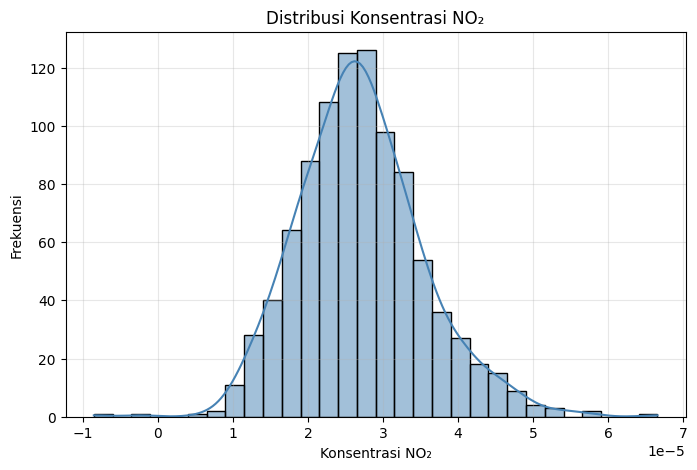

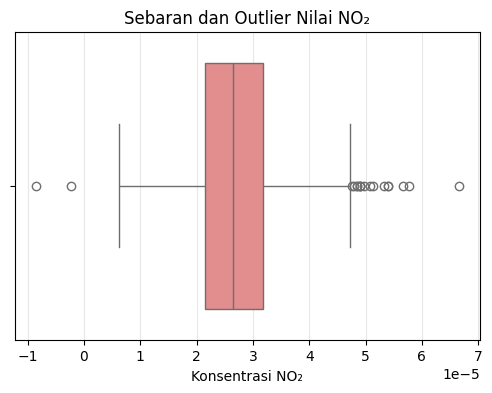

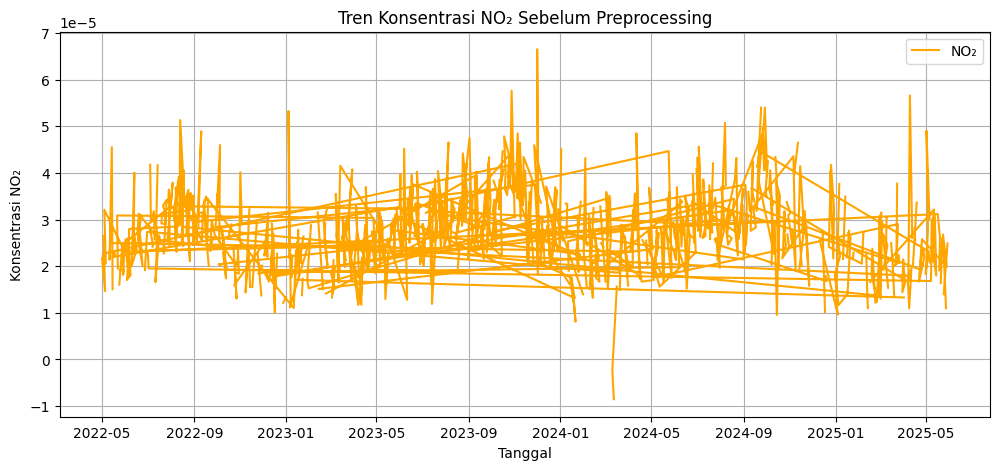

In [7]:
# Statistik deskriptif
print("\n📈 Statistik Deskriptif:")
print(data.describe())

# Cek missing values
print("\n🕳️ Jumlah Missing Values Tiap Kolom:")
print(data.isnull().sum())

# =========================
# 📈 Distribusi Nilai NO₂
# =========================
plt.figure(figsize=(8, 5))
sns.histplot(data['NO2'], bins=30, kde=True, color='steelblue')
plt.title('Distribusi Konsentrasi NO₂')
plt.xlabel('Konsentrasi NO₂')
plt.ylabel('Frekuensi')
plt.grid(True, alpha=0.3)
plt.show()

# =========================
# 📦 Boxplot (Deteksi Outlier)
# =========================
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['NO2'], color='lightcoral')
plt.title('Sebaran dan Outlier Nilai NO₂')
plt.xlabel('Konsentrasi NO₂')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

# =========================
# 📆 Visualisasi Tren Time Series
# =========================
plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(data['date']), data['NO2'], label='NO₂', color='orange')
plt.title('Tren Konsentrasi NO₂ Sebelum Preprocessing')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂')
plt.legend()
plt.grid(True)
plt.show()

### Preprocessing data
Tahapan preprocessing meliputi:
1. **Pengecekan dan penanganan missing values**  \
   Menghapus atau mengisi data yang hilang agar model tidak bias.
2. **Pembersihan data anomali/outlier** \
   Menangani nilai ekstrem yang mungkin muncul akibat kesalahan sensor.
3. **Konversi format tanggal** \
   Memastikan kolom tanggal diubah menjadi format `datetime` agar bisa diolah sebagai time series.


🔧 Tahap Preprocessing:
🕳️ Missing values sebelum interpolasi: 181
✅ Missing values setelah interpolasi: 1

📏 Batas bawah: 0.00, Batas atas: 0.00
⚠️ Jumlah outlier terdeteksi: 21

✅ Data setelah preprocessing:
                       date  feature_index       NO2
0 2022-04-30 00:00:00+00:00              0       NaN
1 2022-05-01 00:00:00+00:00              0  0.000022
2 2022-05-02 00:00:00+00:00              0  0.000022
3 2022-05-03 00:00:00+00:00              0  0.000027
4 2022-05-04 00:00:00+00:00              0  0.000032


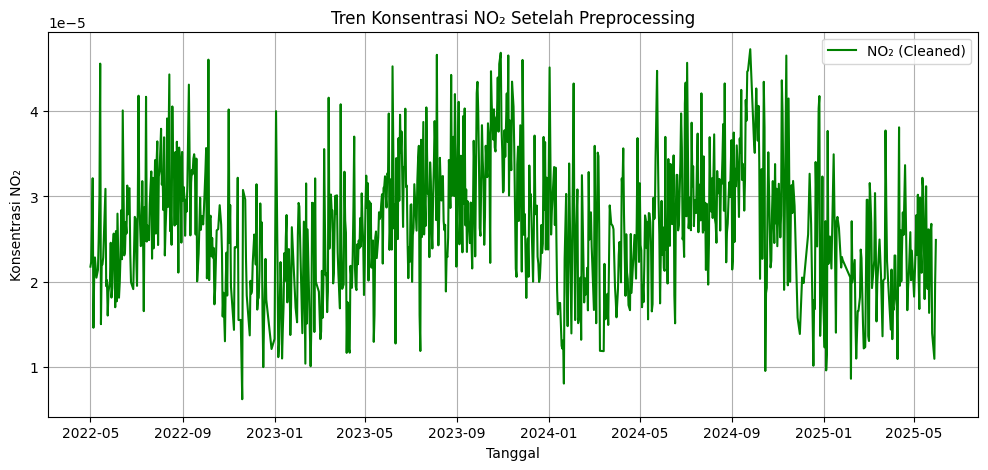

♻️ File lama 'hasil_preprocessing.csv' dihapus, diganti dengan versi terbaru.

💾 File hasil preprocessing disimpan sebagai: hasil_preprocessing.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("\n🔧 Tahap Preprocessing:")

# 1️⃣ Baca dataset
data = pd.read_csv("no2_nganjuk_2022_2025.csv")

# 2️⃣ Ubah kolom tanggal menjadi datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# 3️⃣ Hapus baris dengan tanggal tidak valid
data = data.dropna(subset=['date'])

# 4️⃣ Sortir berdasarkan tanggal
data = data.sort_values(by='date').reset_index(drop=True)

# 5️⃣ Jadikan kolom 'date' sebagai index sebelum interpolasi
data = data.set_index('date')

# 6️⃣ Cek jumlah missing value sebelum interpolasi
if 'NO2' in data.columns:
    missing_before = data['NO2'].isna().sum()
    print(f"🕳️ Missing values sebelum interpolasi: {missing_before}")

    # Interpolasi berbasis waktu
    data['NO2'] = data['NO2'].interpolate(method='time')

    missing_after = data['NO2'].isna().sum()
    print(f"✅ Missing values setelah interpolasi: {missing_after}")

# 7️⃣ Deteksi dan hapus outlier menggunakan metode IQR
q1 = data['NO2'].quantile(0.25)
q3 = data['NO2'].quantile(0.75)
iqr = q3 - q1
batas_bawah = q1 - 1.5 * iqr
batas_atas = q3 + 1.5 * iqr
print(f"\n📏 Batas bawah: {batas_bawah:.2f}, Batas atas: {batas_atas:.2f}")

# Tandai outlier sebagai NaN untuk diinterpolasi ulang
outlier_count = ((data['NO2'] < batas_bawah) | (data['NO2'] > batas_atas)).sum()
print(f"⚠️ Jumlah outlier terdeteksi: {outlier_count}")
data.loc[(data['NO2'] < batas_bawah) | (data['NO2'] > batas_atas), 'NO2'] = np.nan

# 8️⃣ Interpolasi ulang setelah outlier dihapus
data['NO2'] = data['NO2'].interpolate(method='time')

# 9️⃣ Reset index agar kolom date kembali muncul
data = data.reset_index()

# 🔟 Cek hasil akhir preprocessing
print("\n✅ Data setelah preprocessing:")
print(data.head())

# 🔢 Visualisasi hasil preprocessing
plt.figure(figsize=(12, 5))
plt.plot(data['date'], data['NO2'], label='NO₂ (Cleaned)', color='green')
plt.title('Tren Konsentrasi NO₂ Setelah Preprocessing')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂')
plt.legend()
plt.grid(True)
plt.show()

# 1️⃣1️⃣ Simpan hasil preprocessing (replace jika sudah ada)
output_file = "hasil_preprocessing.csv"
if os.path.exists(output_file):
    os.remove(output_file)
    print(f"♻️ File lama '{output_file}' dihapus, diganti dengan versi terbaru.")

data.to_csv(output_file, index=False)
print(f"\n💾 File hasil preprocessing disimpan sebagai: {output_file}")


### Transformasi Time Series ke Supervised Learning
Data time series diubah ke bentuk supervised agar bisa digunakan oleh model regresi seperti KNN.  
Contoh transformasi:
| t-2 | t-1 | t |
|-----|-----|---|
| 10  | 12  | 15 |

Artinya, nilai hari ke-t diprediksi berdasarkan dua hari sebelumnya.



📊 Analisis Korelasi 30 Hari Sebelumnya:
       Fitur  Korelasi
0   NO2(t-1)  0.571153
1   NO2(t-2)  0.409580
2   NO2(t-5)  0.379949
3   NO2(t-3)  0.376875
4   NO2(t-4)  0.364222
5   NO2(t-7)  0.350583
6   NO2(t-6)  0.349390
7   NO2(t-8)  0.341263
8  NO2(t-11)  0.341005
9  NO2(t-12)  0.335452

💾 Hasil korelasi 30 hari sebelumnya disimpan sebagai: hasil_korelasi_30hari.csv


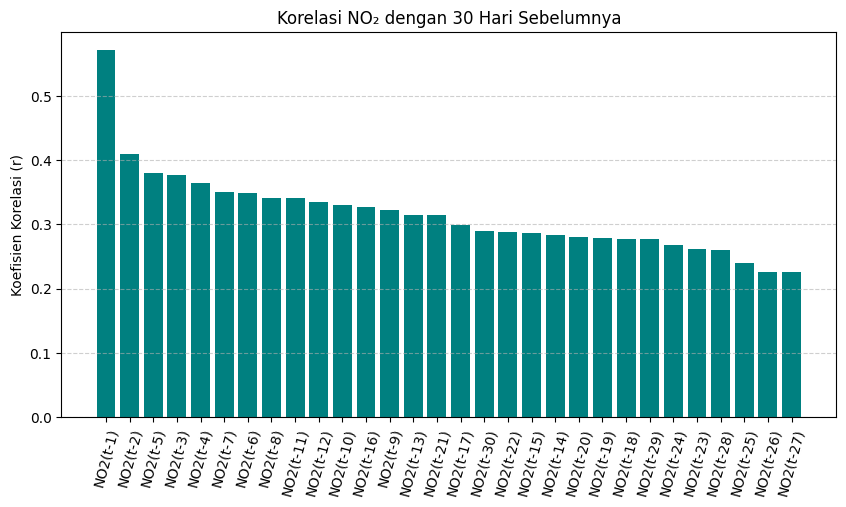

In [10]:
print("\n📊 Analisis Korelasi 30 Hari Sebelumnya:")

# Jadikan kembali NO2 sebagai time series
data = data.set_index('date')

# Buat 30 fitur lag (NO2 t-1 sampai t-30)
for i in range(1, 31):
    data[f'NO2(t-{i})'] = data['NO2'].shift(i)

# Hapus baris yang memiliki NaN karena lag
data_lag = data.dropna()

# Hitung korelasi tiap lag terhadap nilai saat ini
corrs = {}
for i in range(1, 31):
    corrs[f'NO2(t-{i})'] = data_lag['NO2'].corr(data_lag[f'NO2(t-{i})'])

# Ubah ke DataFrame untuk analisis
corr_df = pd.DataFrame(list(corrs.items()), columns=['Fitur', 'Korelasi'])
corr_df = corr_df.sort_values(by='Korelasi', ascending=False).reset_index(drop=True)

print(corr_df.head(10))  # tampilkan 10 fitur lag dengan korelasi tertinggi

# Simpan hasil korelasi
corr_df.to_csv("hasil_korelasi_30hari.csv", index=False)
print("\n💾 Hasil korelasi 30 hari sebelumnya disimpan sebagai: hasil_korelasi_30hari.csv")

# Visualisasi korelasi
plt.figure(figsize=(10, 5))
plt.bar(corr_df['Fitur'], corr_df['Korelasi'], color='teal')
plt.xticks(rotation=75)
plt.title("Korelasi NO₂ dengan 30 Hari Sebelumnya")
plt.ylabel("Koefisien Korelasi (r)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


🎯 Seleksi Fitur Berdasarkan Korelasi:
✅ 2 fitur terpilih dengan korelasi >= 0.4:
      Fitur  Korelasi
0  NO2(t-1)  0.571153
1  NO2(t-2)  0.409580

💾 File fitur terpilih disimpan sebagai: fitur_terpilih.csv
💾 Dataset dengan fitur terpilih disimpan sebagai: data_fitur_terpilih.csv


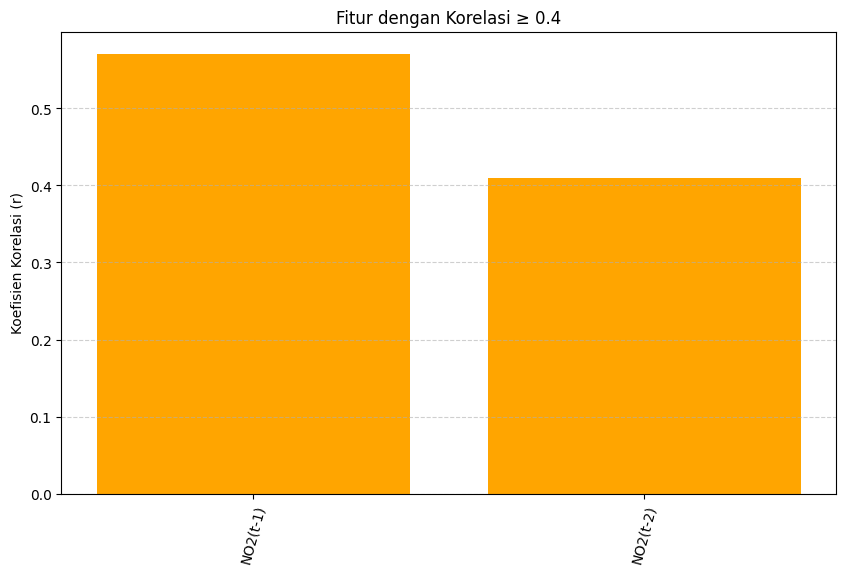

In [14]:
# ======================================================
# 🎯 SELEKSI FITUR BERDASARKAN NILAI KORELASI
# ======================================================

print("\n🎯 Seleksi Fitur Berdasarkan Korelasi:")

# Tentukan ambang batas korelasi
batas_korelasi = 0.4  # bisa diubah sesuai kebutuhan

# Pilih fitur yang memiliki korelasi >= ambang batas
fitur_terpilih = corr_df[corr_df['Korelasi'].abs() >= batas_korelasi]

# Tampilkan hasil fitur terpilih
if fitur_terpilih.empty:
    print(f"Tidak ada fitur dengan korelasi >= {batas_korelasi}.")
else:
    print(f"✅ {len(fitur_terpilih)} fitur terpilih dengan korelasi >= {batas_korelasi}:")
    print(fitur_terpilih)

# Simpan hasil seleksi fitur ke file CSV
fitur_terpilih.to_csv("fitur_terpilih.csv", index=False)
print("\n💾 File fitur terpilih disimpan sebagai: fitur_terpilih.csv")

# ======================================================
# 🔍 Opsional: Buat DataFrame baru hanya dengan fitur terpilih
# ======================================================

# Ambil nama-nama kolom lag yang terpilih
fitur_terpilih_nama = fitur_terpilih['Fitur'].tolist()

# Buat dataset baru yang hanya berisi NO2 saat ini dan fitur lag terpilih
selected_data = data_lag[['NO2'] + fitur_terpilih_nama]

# Simpan hasil data dengan fitur terpilih
selected_data.to_csv("data_fitur_terpilih.csv", index=True)
print("💾 Dataset dengan fitur terpilih disimpan sebagai: data_fitur_terpilih.csv")

# Visualisasi hubungan fitur terpilih dengan target
plt.figure(figsize=(10, 6))
plt.bar(fitur_terpilih['Fitur'], fitur_terpilih['Korelasi'], color='orange')
plt.title(f"Fitur dengan Korelasi ≥ {batas_korelasi}")
plt.ylabel("Koefisien Korelasi (r)")
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Normalisasi Data
Normalisasi digunakan agar semua fitur memiliki skala yang seragam.
Terdapat dua metode utama:
- **Min-Max Scaling** → mengubah nilai ke rentang [0, 1]
- **Z-Score Standardization** → menormalkan berdasarkan distribusi rata-rata dan deviasi standar

Normalisasi penting untuk model KNN karena jarak antar titik sangat bergantung pada skala fitur.



⚙️ Normalisasi Data pada Fitur Terpilih

💾 File hasil normalisasi disimpan sebagai:
- hasil_normalisasi_minmax.csv
- hasil_normalisasi_zscore.csv


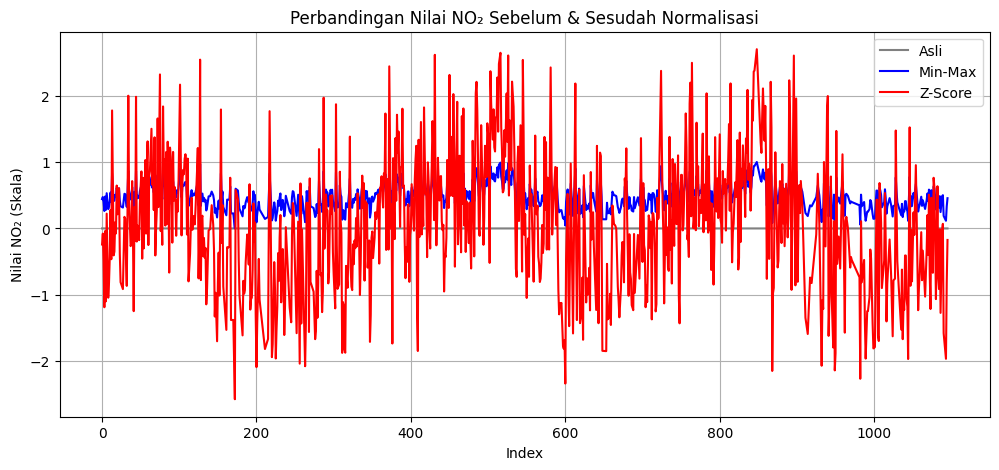

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("\n⚙️ Normalisasi Data pada Fitur Terpilih")

# Gunakan data hasil seleksi fitur
data_normalisasi = selected_data.copy()

# --- Normalisasi Min-Max ---
minmax_scaler = MinMaxScaler()
scaled_minmax = pd.DataFrame(
    minmax_scaler.fit_transform(data_normalisasi),
    columns=data_normalisasi.columns,
    index=data_normalisasi.index
)

# --- Normalisasi Z-Score ---
zscore_scaler = StandardScaler()
scaled_zscore = pd.DataFrame(
    zscore_scaler.fit_transform(data_normalisasi),
    columns=data_normalisasi.columns,
    index=data_normalisasi.index
)

# Simpan hasil normalisasi
scaled_minmax.to_csv("hasil_normalisasi_minmax.csv", index=True)
scaled_zscore.to_csv("hasil_normalisasi_zscore.csv", index=True)

print("\n💾 File hasil normalisasi disimpan sebagai:")
print("- hasil_normalisasi_minmax.csv")
print("- hasil_normalisasi_zscore.csv")

# Visualisasi perbandingan sebelum & sesudah normalisasi
plt.figure(figsize=(12, 5))
plt.plot(data_normalisasi.iloc[:, 0].values, label='Asli', color='gray')
plt.plot(scaled_minmax.iloc[:, 0].values, label='Min-Max', color='blue')
plt.plot(scaled_zscore.iloc[:, 0].values, label='Z-Score', color='red')
plt.title('Perbandingan Nilai NO₂ Sebelum & Sesudah Normalisasi')
plt.xlabel('Index')
plt.ylabel('Nilai NO₂ (Skala)')
plt.legend()
plt.grid(True)
plt.show()


### Model KNN Regression
Setelah data siap, dilakukan eksperimen menggunakan **K-Nearest Neighbors Regression**.
- Model ini bekerja dengan mencari *k* tetangga terdekat untuk memprediksi nilai baru.
- Digunakan untuk memprediksi kadar NO₂ hari berikutnya berdasarkan pola historis.

Eksperimen dilakukan dengan mencoba beberapa variasi:
- Jumlah lag berbeda (misalnya 1, 3, 7 hari)
- Nilai `k` berbeda untuk model KNN
Tujuannya adalah untuk mengetahui **berapa lag optimal** yang paling memengaruhi hasil prediksi.


#### Import dan Persiapan Data

In [31]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump
import matplotlib.pyplot as plt

print("📥 Membaca data hasil seleksi fitur...")

try:
    selected_data = pd.read_csv("data_fitur_terpilih.csv")
    print("✅ File 'data_fitur_terpilih.csv' ditemukan dan digunakan.")
except FileNotFoundError:
    print("⚠️ File 'data_fitur_terpilih.csv' tidak ditemukan. Menggunakan hasil_preprocessing.csv.")
    selected_data = pd.read_csv("hasil_preprocessing.csv")

# Pastikan data tidak memiliki nilai NaN
selected_data = selected_data.dropna()

print(selected_data.head())

📥 Membaca data hasil seleksi fitur...
✅ File 'data_fitur_terpilih.csv' ditemukan dan digunakan.
                        date       NO2  NO2(t-1)  NO2(t-2)
0  2022-05-31 00:00:00+00:00  0.000024  0.000019  0.000018
1  2022-06-01 00:00:00+00:00  0.000026  0.000024  0.000019
2  2022-06-02 00:00:00+00:00  0.000022  0.000026  0.000024
3  2022-06-03 00:00:00+00:00  0.000017  0.000022  0.000026
4  2022-06-04 00:00:00+00:00  0.000026  0.000017  0.000022


#### Memisahkan FItur dengan Target

In [22]:
data = pd.read_csv("data_fitur_terpilih.csv")

# Pastikan kolom tanggal diubah ke datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')


In [23]:
# Buat fitur waktu tambahan
data['dayofyear'] = data['date'].dt.dayofyear
data['month'] = data['date'].dt.month
data['dayofweek'] = data['date'].dt.dayofweek

In [24]:
# Siapkan fitur dan target
fitur = ['dayofyear', 'month', 'dayofweek', 'NO2(t-1)', 'NO2(t-2)']
X = data[fitur]
y = data['NO2']

#### Split Data Training dan Data Test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#### Latih Model KNN Regression

In [26]:
model = KNeighborsRegressor(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)

KNeighborsRegressor(weights='distance')

### Prediksi dan Evaluasi Model
Evaluasi dilakukan dengan metrik seperti:
- **MAPE (Mean Absolute Percentage Error)** 
- **MAE (Mean Absolute Error)**
- **RMSE (Root Mean Square Error)**
- **R² Score**

In [27]:
y_pred = model.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 HASIL EVALUASI MODEL KNN REGRESSION:")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")



📊 HASIL EVALUASI MODEL KNN REGRESSION:
RMSE : 0.000
MAE  : 0.000
MAPE : 30.32%
R²   : -0.276


#### Menyimpan Model

In [34]:
from joblib import dump
joblib.dump(model, "model_knn_no2.pkl")
print("\n💾 Model disimpan sebagai: model_knn_no2.pkl")


NameError: name 'joblib' is not defined

#### Interpretasi Kualitas Udara

In [35]:
def kategori_no2(nilai):
    if nilai < 0.00002:
        return "Bagus"
    elif nilai < 0.00004:
        return "Normal"
    else:
        return "Tidak Sehat"

data_eval = X_test.copy()
data_eval['NO2_aktual'] = y_test
data_eval['NO2_prediksi'] = y_pred
data_eval['Kategori'] = data_eval['NO2_prediksi'].apply(kategori_no2)

print("\n🔎 Contoh hasil prediksi:")
print(data_eval.head())


🔎 Contoh hasil prediksi:
     dayofyear  month  dayofweek  NO2(t-1)  NO2(t-2)  NO2_aktual  \
876        297     10          2  0.000022  0.000026    0.000022   
877        298     10          3  0.000022  0.000022    0.000028   
878        299     10          4  0.000028  0.000022    0.000032   
879        300     10          5  0.000032  0.000028    0.000027   
880        301     10          6  0.000027  0.000032    0.000025   

     NO2_prediksi Kategori  
876      0.000031   Normal  
877      0.000029   Normal  
878      0.000030   Normal  
879      0.000033   Normal  
880      0.000035   Normal  


#### Visualisasi Prediksi

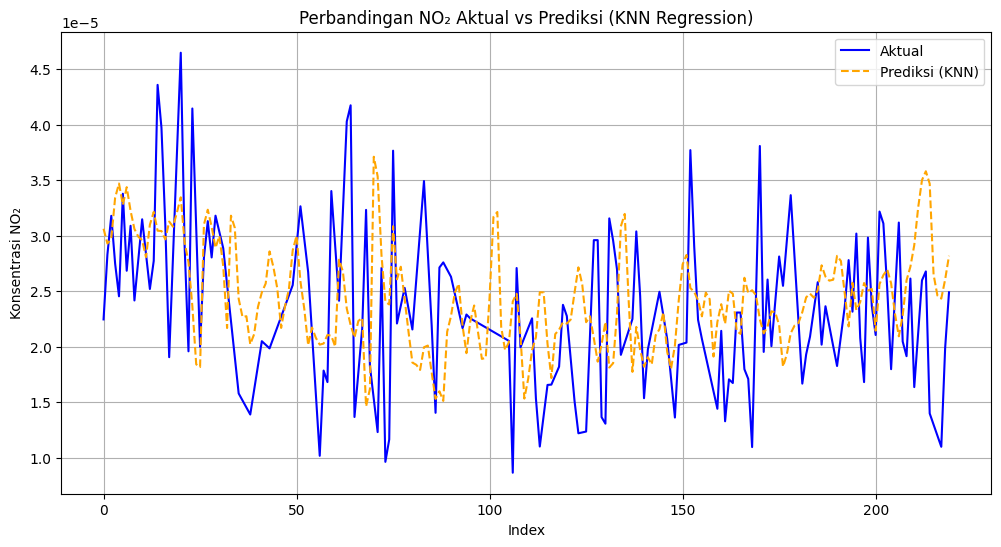

In [36]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Aktual", color='blue')
plt.plot(y_pred, label="Prediksi (KNN)", color='orange', linestyle='--')
plt.title("Perbandingan NO₂ Aktual vs Prediksi (KNN Regression)")
plt.xlabel("Index")
plt.ylabel("Konsentrasi NO₂")
plt.legend()
plt.grid(True)
plt.show()